### 1. Data Loading & Initialization
### Purpose:

Installs and loads Seurat and dependencies for single-cell RNA-seq analysis.

Reads raw gene expression data (pancreas_counts.csv) and a cell metadata (metadata_FACS.csv).

In [36]:
install.packages("Seurat")
install.packages("gt")

library(Seurat)
library(dplyr)
library(ggplot2)
library(patchwork)


Warning message:
"package 'Seurat' is in use and will not be installed"
Installing package into 'C:/Users/Ermias/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'gt' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Ermias\AppData\Local\Temp\Rtmp29MJmG\downloaded_packages


In [4]:
# 1. Data Loading & Initialization -------------------------------------------
# Load raw count data and metadata directly from CSV files
raw_counts <- read.csv("C:\\Users\\Ermias\\Documents\\data visualization\\scRNA.file\\FACS\\pancreas_counts.csv", row.names = 1)

metadata <- read.csv("C:\\Users\\Ermias\\Desktop\\seurat.project\\scRNA.file\\metadata_FACS.csv", row.names = 1)

# Convert raw_counts to a matrix (if it's a data frame)
raw_counts <- as.matrix(raw_counts)

# Optionally, ensure no underscores in feature names
rownames(raw_counts) <- gsub("_", "-", rownames(raw_counts))

# Create Seurat object
pancreas <- CreateSeuratObject(counts = raw_counts, 
                               project = "pancreas_study", 
                               min.cells = 3, 
                               min.features = 200) 

Warning message:
"Data is of class matrix. Coercing to dgCMatrix."


In [5]:
# Check the length of both
length(rownames(metadata))
length(colnames(pancreas))
str(metadata)
# Assuming the column to be used as row names is "cell_id" (replace with actual column name)
rownames(metadata) <- metadata$cell_id
metadata$cell_id <- NULL  # Optionally remove this column if it's no longer needed
# Check if row names of metadata match column names of Seurat object
identical(rownames(metadata), colnames(pancreas))
# Reorder metadata by matching cell identifiers with Seurat object column names
metadata <- metadata[match(colnames(pancreas), metadata$cell_id), ]
rownames(metadata) <- colnames(pancreas)


[1] 247

[1] 1872

'data.frame':	247 obs. of  5 variables:
 $ mouse.id      : chr  "3_8_M" "3_9_M" "3_10_M" "3_56_F" ...
 $ tissue        : chr  "Bladder" "Bladder" "Bladder" "Bladder" ...
 $ subtissue     : chr  NA NA NA NA ...
 $ FACS.selection: chr  "Multiple" "Multiple" "Multiple" "Multiple" ...
 $ mouse.sex     : chr  "M" "M" "M" "F" ...


[1] FALSE

In [6]:
# Add metadata to Seurat object
pancreas<- AddMetaData(pancreas, metadata = metadata)

# Select tissue with 2 or more sub-tissues
# Adjust path to your specific data
head(pancreas@meta.data)
selected_tissue <- pancreas@meta.data %>% filter(!is.na(subtissue) & subtissue >= 2)


,orig.ident,nCount_RNA,nFeature_RNA,mouse.id,tissue,subtissue,FACS.selection,mouse.sex
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
B21.MAA000574.3_8_M.1.1,pancreas_study,4932310,2854,NA,NA,NA,NA,NA
D12.MAA000574.3_8_M.1.1,pancreas_study,1139900,346,NA,NA,NA,NA,NA
B22.MAA000574.3_8_M.1.1,pancreas_study,5790505,2521,NA,NA,NA,NA,NA
D13.MAA000574.3_8_M.1.1,pancreas_study,1986467,4166,NA,NA,NA,NA,NA
C1.MAA000574.3_8_M.1.1,pancreas_study,525766,229,NA,NA,NA,NA,NA
D14.MAA000574.3_8_M.1.1,pancreas_study,1285236,1477,NA,NA,NA,NA,NA


### 2. Quality Control (QC)
### Purpose:

Identifies cells with high mitochondrial gene content (indicates apoptosis or stress).

Filters cells with too few/many genes or high mitochondrial content.

Warning message:
"Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead."
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
"All cells have the same value of percent.mt."


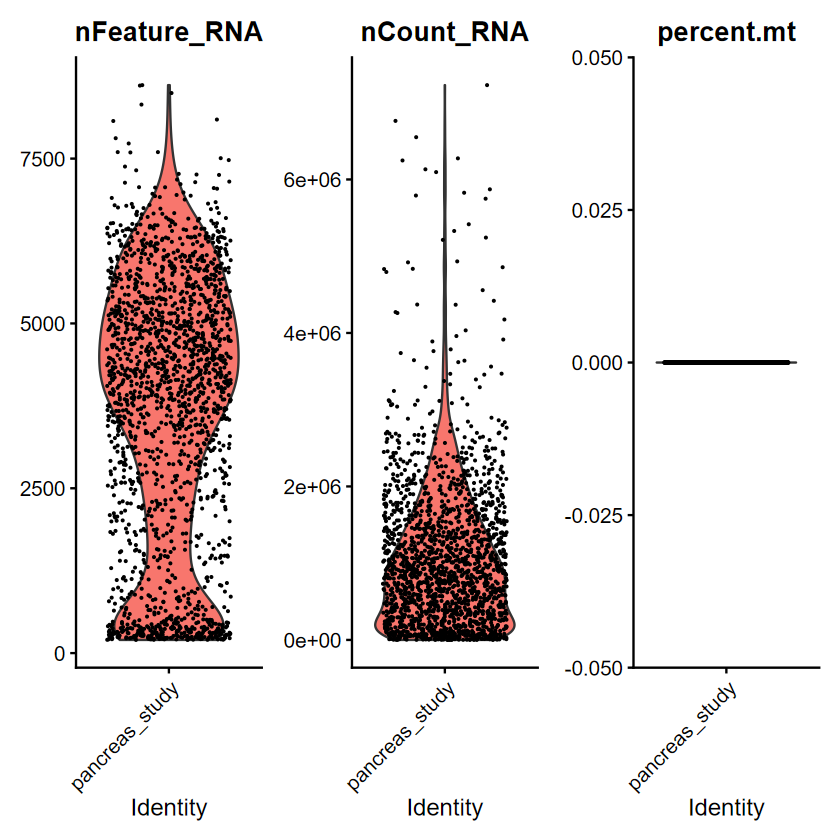

In [7]:
### 2. Quality Control Metrics -------------------------------------------------
pancreas[["percent.mt"]] <- PercentageFeatureSet(pancreas, pattern = "^MT-")

# Visual QC metrics
VlnPlot(pancreas, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


Warning message in cor(x = data[, 1], y = data[, 2]):
"the standard deviation is zero"


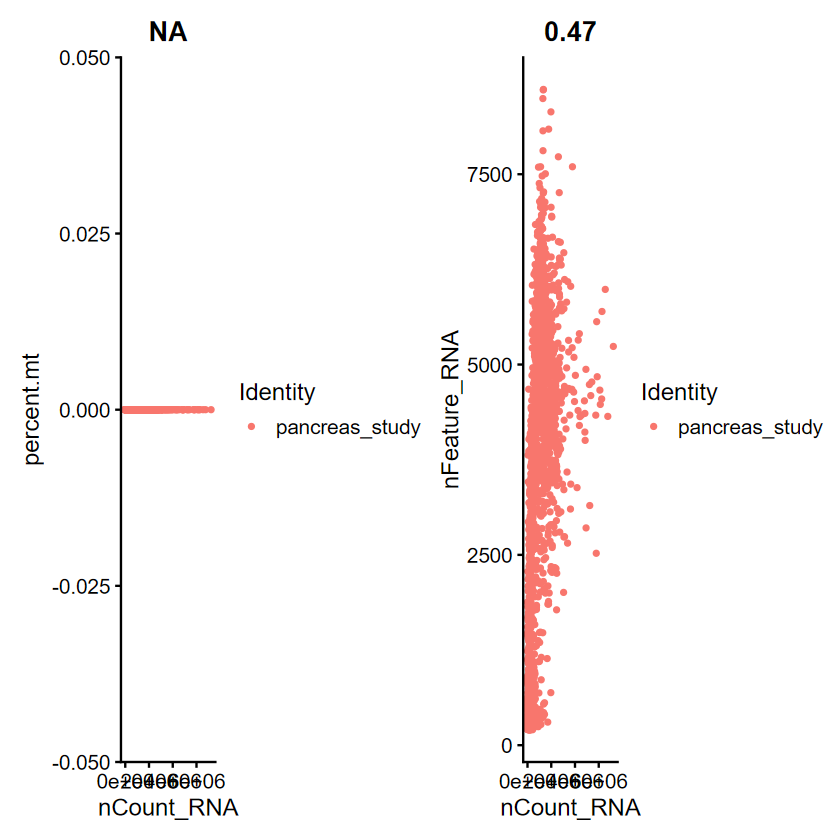

In [8]:
# Feature correlation plots
plot1 <- FeatureScatter(pancreas, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pancreas, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

# Filter based on QC metrics
pancreas <- subset(pancreas, subset = nFeature_RNA > 200 & 
                     nFeature_RNA < 2500 & 
                     percent.mt < 5)


### 3. Data Normalization & Feature Selection

Normalizing layer: counts

Finding variable features for layer counts



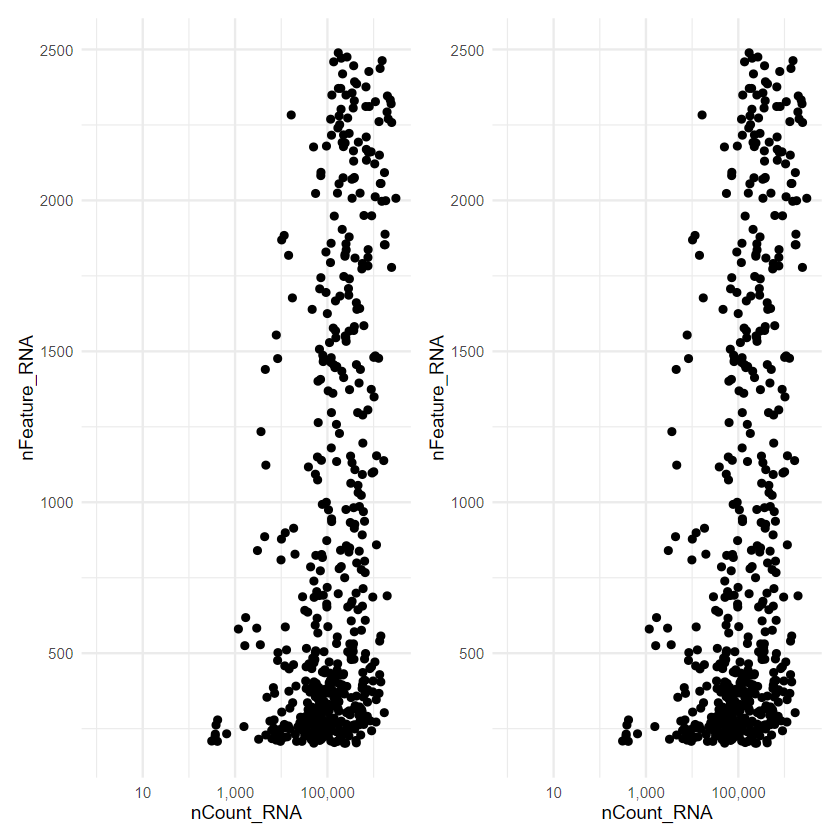

In [9]:
### 3. Data Processing ---------------------------------------------------------

# Normalize data and find variable features
pancreas <- NormalizeData(pancreas)
pancreas <- FindVariableFeatures(pancreas, selection.method = "vst", nfeatures = 2000)

# Remove rows with zero or negative values for the x-axis variable (e.g., nCount_RNA)
clean_data <- subset(pancreas@meta.data, nCount_RNA > 0)

# Visualize data using ggplot2
plot1 <- ggplot(clean_data, aes(x = nCount_RNA, y = nFeature_RNA)) + 
  geom_point() +
  scale_x_log10(labels = scales::comma, limits = c(1, NA)) +
  theme_minimal()
plot2 <- ggplot(clean_data, aes(x = nCount_RNA, y = nFeature_RNA)) + 
  geom_point() +
  scale_x_log10(labels = scales::comma, limits = c(1, NA)) +
  theme_minimal()
plot1 + plot2



### The following chunk of code is all about cleaning up the data and visualizing it after some transformations

Warning message:
"The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead."


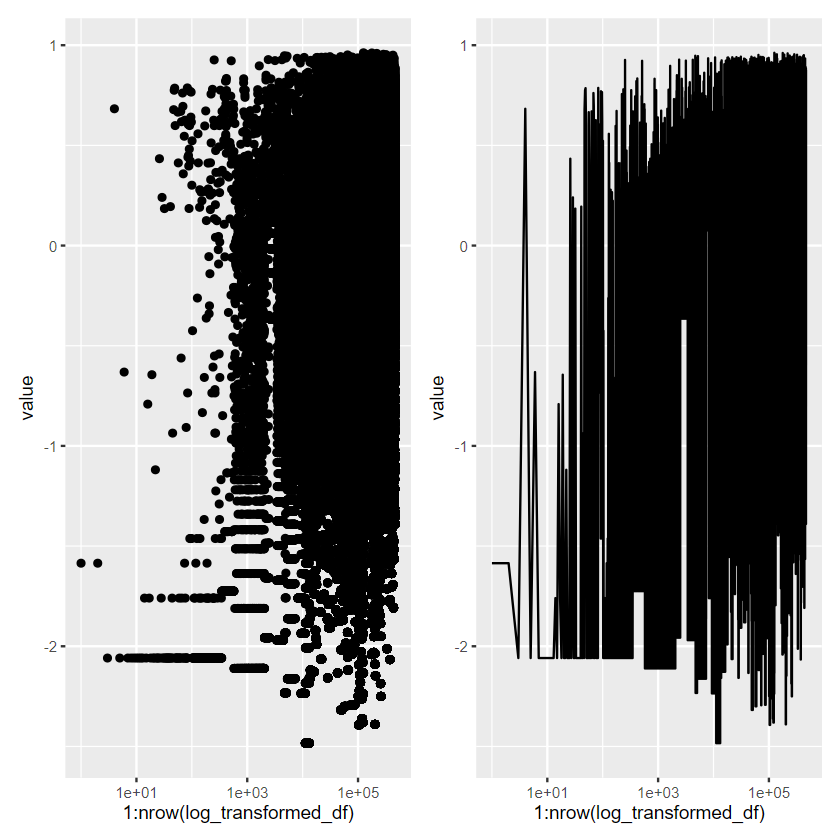

In [10]:
# Log-transformation of positive values
data_matrix <- GetAssayData(pancreas, slot = "data")
positive_data <- data_matrix[data_matrix > 0]
log_transformed_data <- log10(positive_data)
log_transformed_df <- as.data.frame(log_transformed_data)
colnames(log_transformed_df) <- c("value")

# Visualize log-transformed data
plot1 <- ggplot(log_transformed_df, aes(x = 1:nrow(log_transformed_df), y = value)) + 
  geom_point() + 
  scale_x_log10()
plot2 <- ggplot(log_transformed_df, aes(x = 1:nrow(log_transformed_df), y = value)) + 
  geom_line() + 
  scale_x_log10()
combined_plot <- plot1 + plot2
combined_plot


## 4. Scaling, PCA, & Clustering
## Purpose:

PCA reduces dimensionality.

UMAP visualizes clusters.

resolution = 0.5 controls cluster granularity (higher = more clusters).

In [11]:
### 4. Scaling and Dimensionality Reduction -------------------------------------

# Scale data and run PCA
all.genes <- rownames(pancreas)
pancreas <- ScaleData(pancreas, features = all.genes)
pancreas <- RunPCA(pancreas, features = VariableFeatures(object = pancreas))


Centering and scaling data matrix

PC_ 1 
Positive:  Igfbp7, Esam, Tinagl1, Col4a1, Eng, Plvap, Pecam1, H2-D1, Gpr116, S1pr1 
	   Sparcl1, Nrp1, Ltbp4, Timp3, Col4a2, Flt1, Actb, Ly6a, Ly6c1, Acvrl1 
	   Heg1, Sparc, Sdpr, Arhgap31, Cd300lg, Cd34, Id3, Tmem88, Clec14a, Clic4 
Negative:  Pnlip, Cel, Cela2a, Pnliprp1, ERCC-00025, ERCC-00044, ERCC-00157, ERCC-00116, Il22ra1, ERCC-00084 
	   ERCC-00099, ERCC-00170, Zfp189, Tubgcp4, Spryd4, Adck3, BC030476, Neu2, Neb, Qrsl1 
	   Zfp280b, Rnaseh1, Mrps30, Slc1a3, Ndufaf1, Lrrc4, Gata4, Noa1, Ulk4, Rab11fip4 
PC_ 2 
Positive:  Rac2, Selplg, Itgb7, Dusp2, Coro1a, Lat, Tbc1d10c, Rgs1, Ctsw, Cd52 
	   Gm14446, Laptm5, Capza1, Cd3e, Hcls1, Il2rb, Cd53, Sema4d, Hmha1, Rasgrp1 
	   Esyt1, Sept1, Skap1, Trim35, Sh2d2a, Fam105a, Akna, Ms4a6b, Arhgap9, Cd5 
Negative:  Pecam1, Plvap, Flt1, Cd300lg, Kdr, Tmem88, Ly6c1, Fabp4, Gpr116, Emcn 
	   Igfbp3, Thrsp, Cd34, Eng, Clec14a, Sdpr, Ptprb, Scarb1, Ppap2a, Gpihbp1 
	   Arhgap31, Eltd1, Cdh5, Aqp1, S1pr1

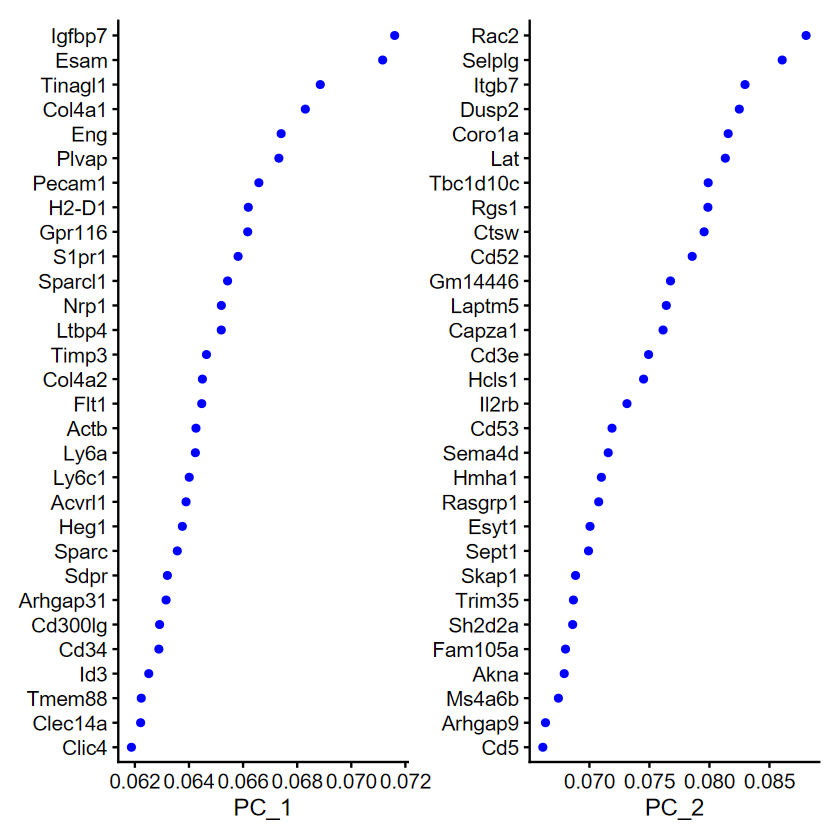

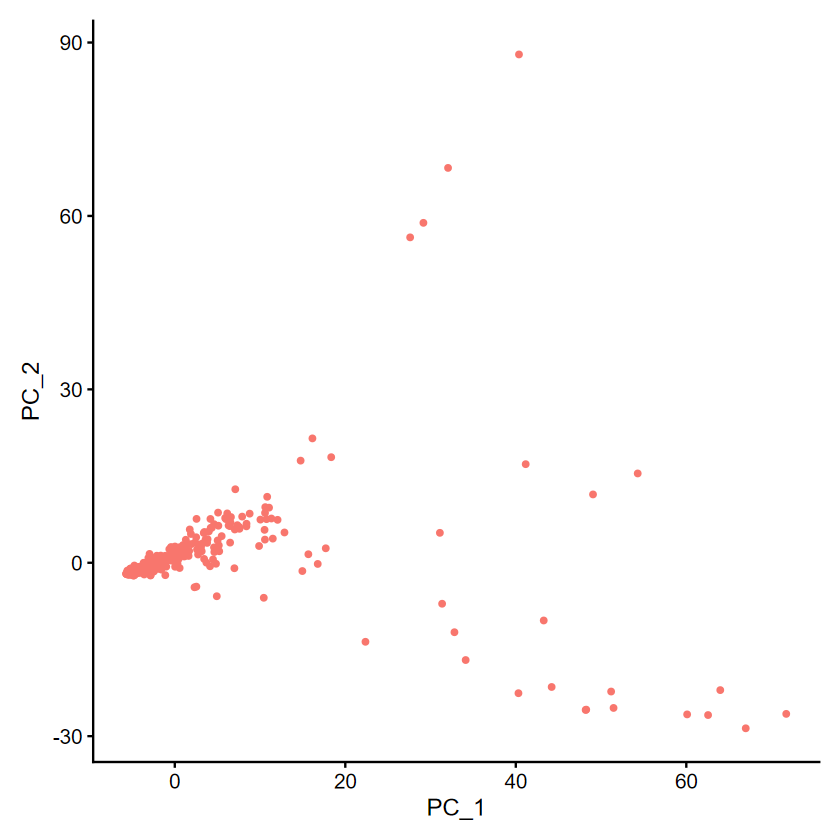

In [12]:
# Examine PCA results
VizDimLoadings(pancreas, dims = 1:2, reduction = "pca")
DimPlot(pancreas, reduction = "pca") + NoLegend()


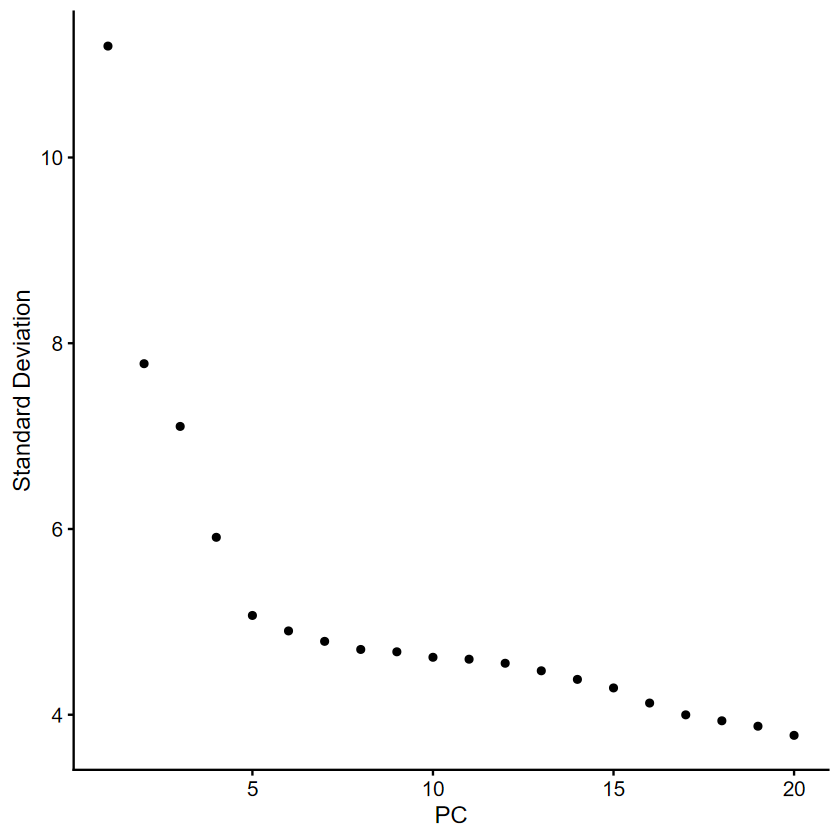

In [13]:
# Determine significant PCs
ElbowPlot(pancreas)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 527
Number of edges: 17806

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7623
Number of communities: 5
Elapsed time: 0 seconds


14:31:38 UMAP embedding parameters a = 0.9922 b = 1.112

14:31:38 Read 527 rows and found 10 numeric columns

14:31:38 Using Annoy for neighbor search, n_neighbors = 30

14:31:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:31:38 Writing NN index file to temp file C:\Users\Ermias\AppData\Local\Temp\Rtmp29MJmG\file183c4bd07936

14:31:38 Searching Annoy index using 1 thread, search_k = 3000

14:31:38 Annoy recall = 100%

14:31:38 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:31:39 Initializing from normalized Laplacian + noise (using RSpectra)

14:31:39 Commencing optimization for 500 epochs, with 23218 positive edges

14:31:40 Optimization finished



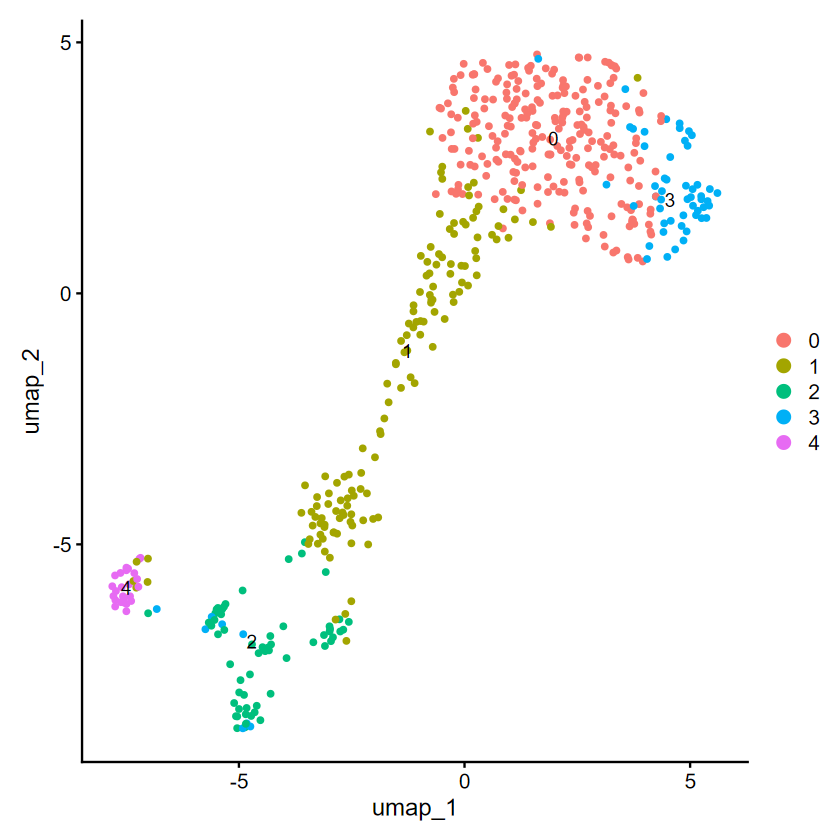

In [15]:
### 5. Clustering and UMAP -----------------------------------------------------
# Perform clustering and UMAP
pancreas <- FindNeighbors(pancreas, dims = 1:10)
pancreas <- FindClusters(pancreas, resolution = 0.5)
pancreas <- RunUMAP(pancreas, dims = 1:10)
# Visualize clusters
DimPlot(pancreas, reduction = "umap", label = TRUE)

## 5. Gender Analysis
## Purpose:

Checks for sex-specific biases in cell clusters.

Useful for identifying batch effects or biological differences.

# New Task
### 1. Recolor UMAP Plot Using mouse.sex


female   male 
   255    272 

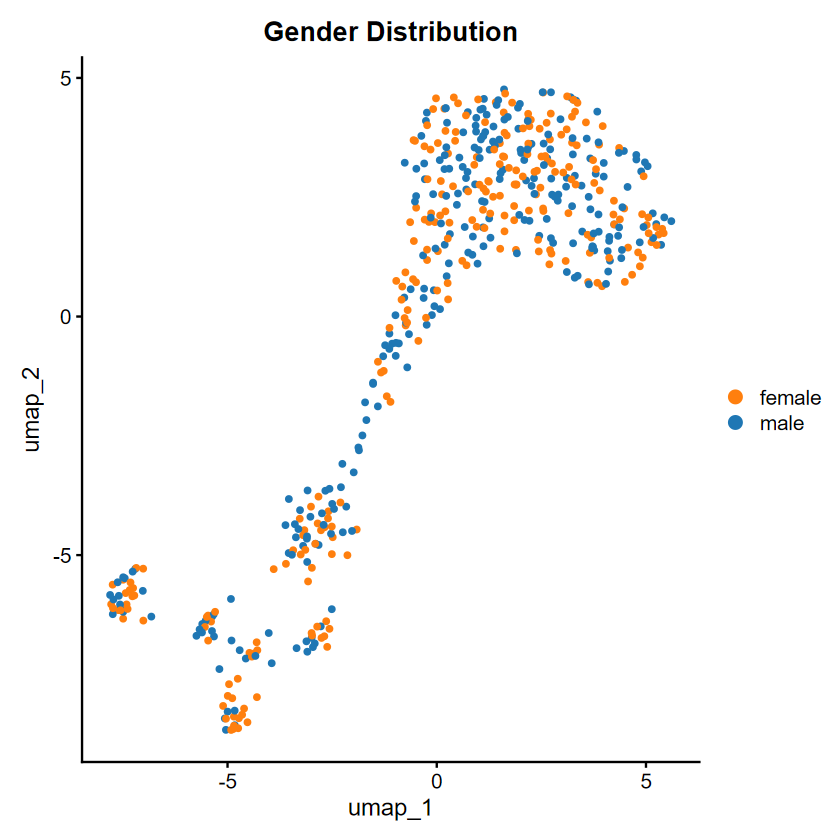

In [19]:
# Ensure gender information is correctly specified
table(pancreas@meta.data$mouse.sex)

# Recolor and visualize gender distribution
DimPlot(pancreas, group.by = "mouse.sex", reduction = "umap",
        cols = c("male" = "#1f77b4", "female" = "#ff7f0e", "NA" = "gray")) +
  ggtitle("Gender Distribution")


### 2. Calculate Gender Percentage for Each Cluster and 
 ### Generate a grouped Bar Chart  OR Stacked Bar Chart for Gender Distribution 

In [43]:
# Count occurrences of each gender in each cluster
cluster_gender_counts <- pancreas@meta.data %>%
  group_by(seurat_clusters, mouse.sex) %>%
  summarise(count = n()) %>%
  mutate(percent = count / sum(count) * 100)
# Display results
print(cluster_gender_counts)

`summarise()` has grouped output by 'seurat_clusters'. You can override using the `.groups` argument.


# A tibble: 10 × 4
# Groups:   seurat_clusters [5]
   seurat_clusters mouse.sex count percent
   <fct>           <chr>     <int>   <dbl>
 1 0               female      121    49.4
 2 0               male        124    50.6
 3 1               female       60    43.2
 4 1               male         79    56.8
 5 2               female       34    57.6
 6 2               male         25    42.4
 7 3               female       26    44.1
 8 3               male         33    55.9
 9 4               female       14    56  
10 4               male         11    44  


In [44]:
library(knitr)
# Create table
kable(cluster_gender_counts, col.names = c("Cluster", "Gender", "Count", "Percentage"))



|Cluster |Gender | Count| Percentage|
|:-------|:------|-----:|----------:|
|0       |female |   121|   49.38776|
|0       |male   |   124|   50.61224|
|1       |female |    60|   43.16547|
|1       |male   |    79|   56.83453|
|2       |female |    34|   57.62712|
|2       |male   |    25|   42.37288|
|3       |female |    26|   44.06780|
|3       |male   |    33|   55.93220|
|4       |female |    14|   56.00000|
|4       |male   |    11|   44.00000|

### Generate a grouped Bar Chart for Gender Distribution

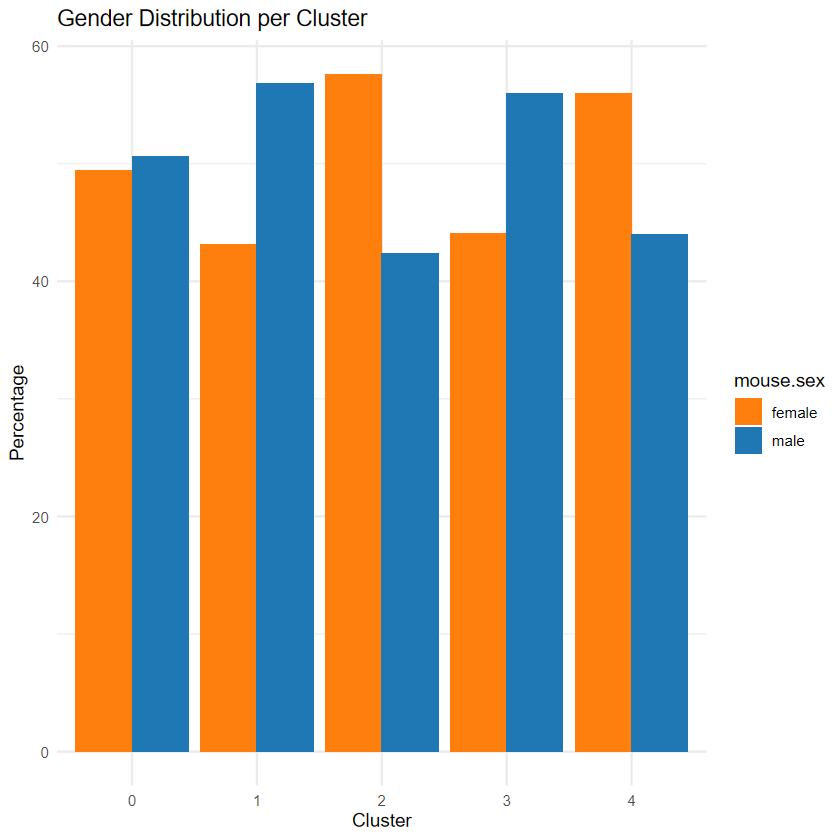

In [42]:
# Generated a grouped bar chart for gender distribution
ggplot(cluster_gender_counts, aes(x = seurat_clusters, y = percent, fill = mouse.sex)) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("male" = "#1f77b4", "female" = "#ff7f0e")) +
  labs(title = "Gender Distribution per Cluster", x = "Cluster", y = "Percentage") +
  theme_minimal()

# OR
### Generate a Stacked  Bar Chart for Gender Distribution

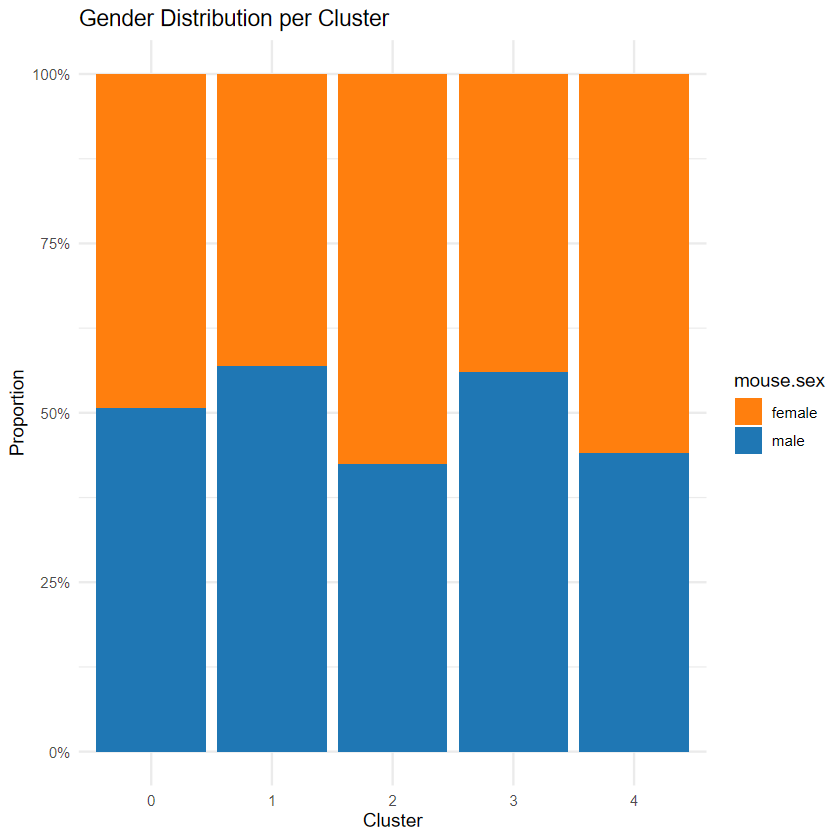

In [23]:
ggplot(cluster_gender_counts, aes(x = seurat_clusters, y = percent, fill = mouse.sex)) +
  geom_bar(stat = "identity", position = "fill") +  # Stacked bar chart with relative proportions
  scale_fill_manual(values = c("male" = "#1f77b4", "female" = "#ff7f0e")) +
  labs(title = "Gender Distribution per Cluster", x = "Cluster", y = "Proportion") +
  scale_y_continuous(labels = scales::percent) +  # Convert y-axis to percentage format
  theme_minimal()

## 6. Sub-Tissue Differential Expression
## Purpose:

Identifies genes differentially expressed between sub-tissues (e.g., tumor vs. normal).

Heatmap highlights top 20 marker genes.

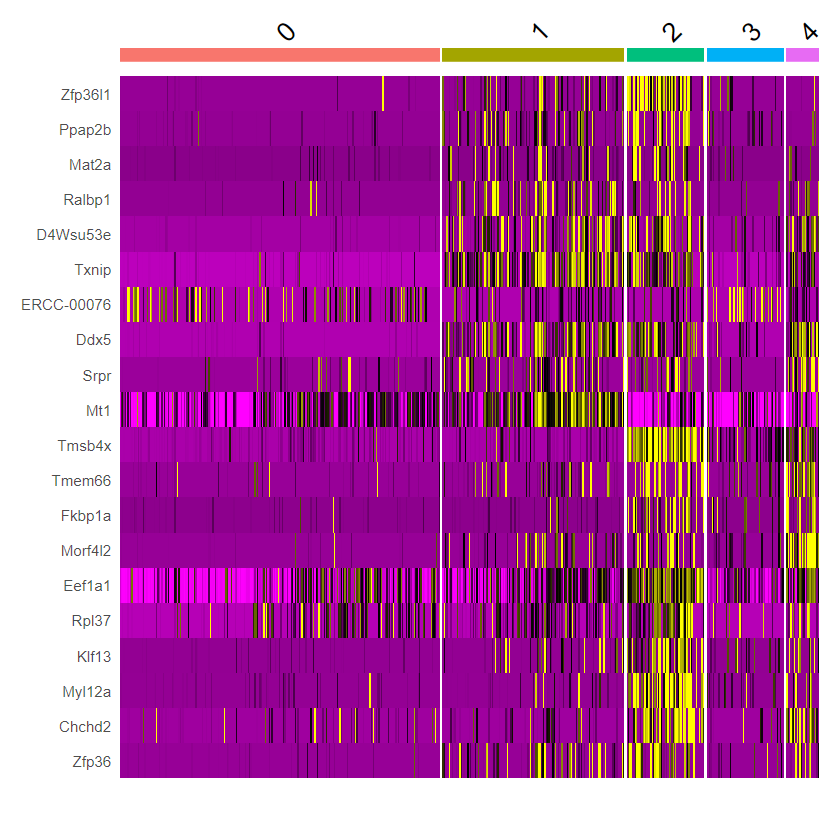

In [54]:
### 7. Differential Expression Analysis Between Sub-Tissues -----------------
# Example tissue and subtissue information (replace with actual data)
tissue_info <- rep(c("TissueType1", "TissueType2"), length.out = nrow(pancreas@meta.data))
subtissue_info <- rep(c("SubtissueType1", "SubtissueType2"), length.out = nrow(pancreas@meta.data))
# Ensure the lengths match the number of cells
if (length(tissue_info) == nrow(pancreas@meta.data) && length(subtissue_info) == nrow(pancreas@meta.data)) {
  pancreas$tissue <- tissue_info
  pancreas$subtissue <- subtissue_info
} else {
  print("Length of tissue_info or subtissue_info vector does not match the number of cells.")
}
# Create subsets
subtissue1 <- subset(pancreas, subset = subtissue == "SubtissueType1")
subtissue2 <- subset(pancreas, subset = subtissue == "SubtissueType2")

# Extract cell identities for sub-tissues
ident1 <- WhichCells(pancreas, expression = subtissue == "SubtissueType1")
ident2 <- WhichCells(pancreas, expression = subtissue == "SubtissueType2")

# Perform differential expression analysis
markers_subtissues <- FindMarkers(pancreas, ident.1 = ident1, ident.2 = ident2, min.pct = 0.25, logfc.threshold = 0.25)


# Heatmap for marker genes between sub-tissues
top_genes <- rownames(markers_subtissues[1:20, ])
DoHeatmap(pancreas, features = top_genes) + NoLegend()

## Save Results


In [55]:
### 8. Save Results -----------------------------------------------------------
saveRDS(pancreas, file = "pancreas_processed.rds")
write.csv(markers_subtissues, "pancreas_markers.csv")

ggsave("pancreas_umap.pdf", 
       plot = DimPlot(pancreas, reduction = "umap", label = TRUE),
       width = 10, height = 8, dpi = 300)

sessionInfo()

R version 4.4.2 (2024-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 26100)

Matrix products: default


locale:
[1] LC_COLLATE=English_United States.utf8 
[2] LC_CTYPE=English_United States.utf8   
[3] LC_MONETARY=English_United States.utf8
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.utf8    

time zone: Europe/Moscow
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.3.0    ggplot2_3.5.1      dplyr_1.1.4        Seurat_5.2.1      
[5] SeuratObject_5.0.2 sp_2.2-0          

loaded via a namespace (and not attached):
  [1] deldir_2.0-4           pbapply_1.7-2          gridExtra_2.3         
  [4] rlang_1.1.5            magrittr_2.0.3         RcppAnnoy_0.0.22      
  [7] spatstat.geom_3.3-5    matrixStats_1.5.0      ggridges_0.5.6        
 [10] compiler_4.4.2         systemfonts_1.2.1      png_0.1-8           

## What steps were exciting for me?
UMAP clustering and collecting cell populations for visualization is one of the coolest parts of my work. the other very interesting thing is that cells are Grouped with a similar pattern of gene expression. Other features of interest were the gender-based UMAP visualizations, which had some fairly surprising insights into how biological sex may influence clustering! I was also interested in the DEGs between the sub-tissues, and more so in how those genes were actually active in the different populations of cells. It felt like hidden layers of biological complexity were being uncovered.

## Curious conclusions from my analysis

#### Sex-Based Clustering Patterns:
There were clusters that comprised individuals of one sex or the other, which indicates attractive biological differences in the expression of specific genes within the context of the data we had. This was an unexpected but striking finding.
#### Sub-Tissue difference: 
The clustering results of RNA-seq qualitatively separated different sub-tissues, which weres verified by DEGs and heatmaps. The data fitted so well with the biology, it was gratifying.
 #### Unique Marker Genes: 
 The additional marker genes that were not in common for all groups were identified. This was another important piece of evidence for the biological dividing line between these tissues, and something I learned a lot from.

## What have I learned from biology after the analysis?

 I learned a tremendous amount about the complexities of gene expression from this analysis. One thing that struck me was how different gene expression can be across tissues — even in tissues from the same organ. At the cellular level, there is some absurd diversity.
 I also learned that there are sex-based differences in gene expression that can be measured at the single-cell level and that understanding this could have important implications for disease. This discovery made me realize that precision medicine might need to update itself taking these differences into account.
 At long last, I used that knowledge to gain a better understanding of single-cell RNA sequencing from the technical perspective. The noise of low quality cells filtered out really helped clean up the clustering results; it is worthy evidence of the importance of data quality to any downstream analysis.